# Rossmann Store Sales
### Developing models to forecast sales

The data for this excericse was obtained from Kaggle (Featured Prediction Competition) site https://www.kaggle.com/c/rossmann-store-sales/data. The descriptions of the data is as follows:

#### Overview
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

#### Data Description
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.


### Files
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- store.csv - supplemental information about the stores

### Data fields
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math 

### Loading the data 

In [2]:
# lading the store details data
store_df = pd.read_csv("store.csv")
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [3]:
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [4]:
store_df.shape

(1115, 10)

In [5]:
# importing training Data
train_df = pd.read_csv("train.csv")
train_df

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
train_df.shape

(1017209, 9)

### Combining the training and store details data
Combining these two dataframes was necessary to get complete information for each store. Since store number is a common feature for both data, the two data were combined on "Store" feature. 

In [7]:
combined_df = pd.merge(train_df, store_df, on='Store')
combined_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [8]:
combined_df.shape

(1017209, 18)

### Exploaratory Data Analysis 

In [9]:
# identifying the data types in the origional data
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [10]:
# checking if there are missing values in the dataset
combined_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [11]:
# unique values in dataset; Data and CompetitionDistance features were removed as they have too many unique values to display 
columns = list(combined_df.columns)
columns.remove('Date')
columns.remove('CompetitionDistance')
for col in columns:
    print(col,"-------->",combined_df[col].unique())

Store --------> [   1    2    3 ... 1113 1114 1115]
DayOfWeek --------> [5 4 3 2 1 7 6]
Sales --------> [ 5263  5020  4782 ... 20362 18841 21237]
Customers --------> [ 555  546  523 ... 3727 4022 4106]
Open --------> [1 0]
Promo --------> [1 0]
StateHoliday --------> ['0' 'a' 'b' 'c' 0]
SchoolHoliday --------> [1 0]
StoreType --------> ['c' 'a' 'd' 'b']
Assortment --------> ['a' 'c' 'b']
CompetitionOpenSinceMonth --------> [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
CompetitionOpenSinceYear --------> [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Promo2 --------> [0 1]
Promo2SinceWeek --------> [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Promo2SinceYear --------> [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
PromoInterval --------> [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [12]:
# extracting year and month values from "Date" feature to use them as independent features
combined_df['Year']  = combined_df['Date'].apply(lambda x: int(str(x)[:4]))
combined_df['Month'] = combined_df['Date'].apply(lambda x: int(str(x)[5:7]))
combined_df = combined_df.drop('Date', 1)

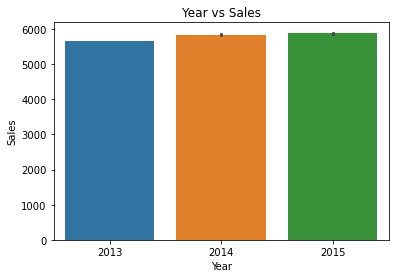

In [13]:
# Plotting Sales with respect to Year 
sns.barplot(x='Year', y='Sales', data=combined_df).set(title='Year vs Sales')
plt.show()

The above plot shows that sales increased years.

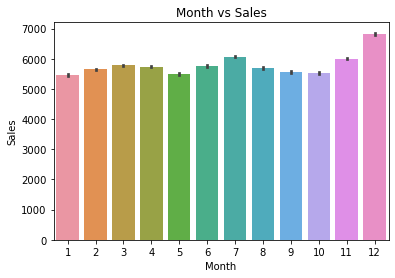

In [14]:
# plotting Sales with respect to Month 
sns.barplot(x='Month', y='Sales', data=combined_df).set(title='Month vs Sales')
plt.show()

Sales were increasing from January to December, May to July and October to December. Sales were decreasing April to May, and more or less stable August to October.

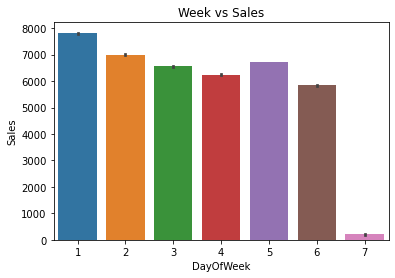

In [16]:
# plotting Sales with respect to DayOfWeek
sns.barplot(x='DayOfWeek', y='Sales', data=combined_df).set(title='Week vs Sales')
plt.show()

Sales were the highes on Monday followed by Friday. There was a decrease of sales from Tuesday to Thuresday. The lowest sales happen on Sunday. 

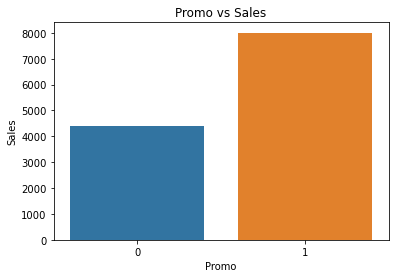

In [17]:
# plotting Sales with respect to Promo
sns.barplot(x='Promo', y='Sales', data=combined_df).set(title='Promo vs Sales')
plt.show()

Sales were higher when there was Promo.

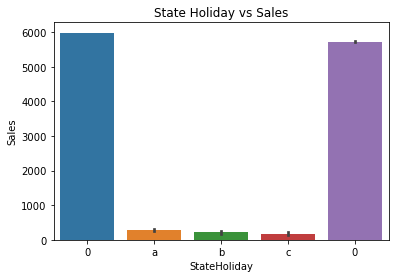

In [19]:
# Plotting Sales with respect to State Holiday
sns.barplot(x='StateHoliday', y='Sales', data=combined_df).set(title='State Holiday vs Sales')
plt.show()

The above plot provided two bars with "0" lebel, which is because of presence of '0' and 0.

In [20]:
combined_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


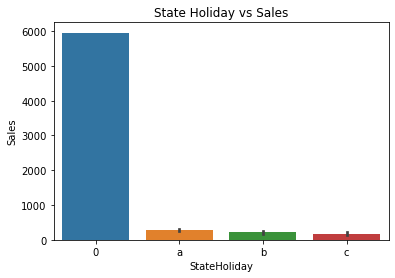

In [21]:
# changing 0 values need to '0' and plotting the corrected "StateHoliday" sales.
combined_df["StateHoliday"].loc[combined_df["StateHoliday"] == 0] = "0"

sns.barplot(x='StateHoliday', y='Sales', data=combined_df).set(title='State Holiday vs Sales')
plt.show()

Since most stores are closed on State Holidays, the Sales were low on "a" (Public Holiday), b (Easter Holiday), and c (Chirstmas). 0 represents None, which means working day

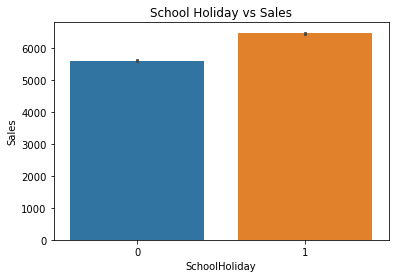

In [27]:
# plotting Sales with respect to School Holiday
sns.barplot(x='SchoolHoliday', y='Sales', data=combined_df).set(title='School Holiday vs Sales')
plt.show()

There were more Sales on School Holidays.

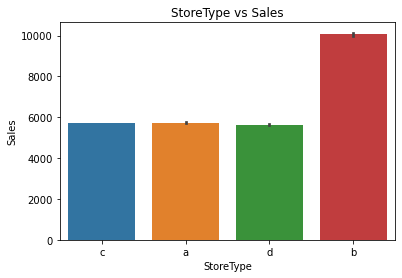

In [23]:
# plotting Sales with respect to StoreType
sns.barplot(x='StoreType', y='Sales', data=combined_df).set(title='StoreType vs Sales')
plt.show()

b type store types had the highest sales. 

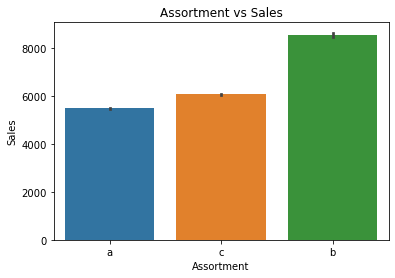

In [24]:
# plotting Sales with respect to Assortment
sns.barplot(x='Assortment', y='Sales', data=combined_df).set(title='Assortment vs Sales')
plt.show()

b (extra) Assortment level yielded the highest Sales.

### Handling missing Values

Few columns have high number of missing values, so we need to fill them with appropriate method for better result

In [25]:
combined_df.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
dtype: int64

In [50]:
store_details.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [52]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

The missing values occure due to missing information in the store details

#### Approaches to complete the missing values
1. The null values in Column Promo2SinceWeek, Promo2SinceYear, and PromoInterval were related to 0 to Promo2 (promotion) for those stores. Hence, the null values in these columns will be completed with 0.

2. CompetitionDistance for 3 stores isn't given as is seen in the store_details data. Perhaps, it may be reasonable to fill them using the mean of distance of all other stores.

3. CompetitionOpenSinceMonth, CompetitionOpenSinceYear can better be filled using the most occuring month and year, respectively. 

In [26]:
# Completing missing values in the Promo2SinceWeek, Promo2SinceYear, PromoInterval columns with 0 as motivated above
combined_df.update(combined_df[['Promo2SinceWeek','Promo2SinceYear','PromoInterval']].fillna(0))

In [27]:
# Completing missing values in the CompetitionDistance with mean distance as motivated above
mean_competition_distance = combined_df['CompetitionDistance'].mean()
combined_df['CompetitionDistance'].fillna(mean_competition_distance, inplace=True)

In [28]:
# Completing missing values in the CompetitionOpenSinceMonth, CompetitionOpenSinceYear with most occuring month and year, respectively
mode_competition_open_month = combined_df['CompetitionOpenSinceMonth'].mode()[0]

mode_competition_open_year = combined_df['CompetitionOpenSinceYear'].mode()[0]

combined_df['CompetitionOpenSinceMonth'].fillna(mode_competition_open_month,inplace=True)
combined_df['CompetitionOpenSinceYear'].fillna(mode_competition_open_year,inplace=True)

In [29]:
# checking of there are still missing values
combined_df.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
dtype: int64

This shows all missing values completed. 

### Treating Outliers

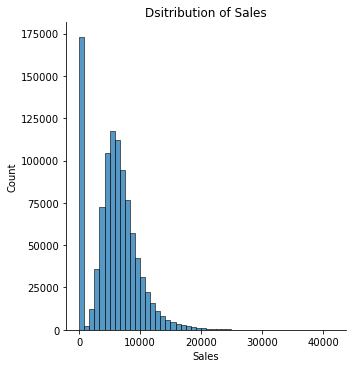

In [30]:
# checking distribution of sales 
sns.displot(combined_df, x="Sales",bins=50).set(title='Dsitribution of Sales')

#### Z-Score to identify ouliers
Z-Score, which is also refered as standard score, helps to identify if a data point is an outlier or not. Z-score helps to understand if a data value is greater or smaller than the mean and how far away it is from the mean. Often z-score of 3 is used as a threshold to identify outliers. Likewise, in this excercise, when the Z-Score of a datapoint is greater than 3, it was considered as an Outlier.

Mean of Sales:  5773.818972305593
Standard Deviation of Sales:  3849.9242828437527
Total outliers in the dataset are:  9731
Maximum Sales Outliers:  41551
Minimum Sales Outliers:  17325


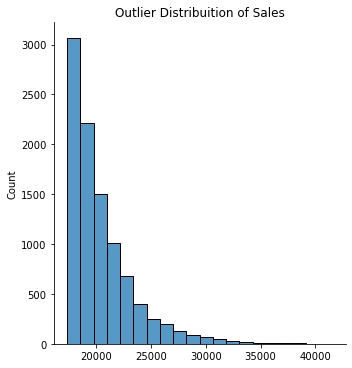

In [31]:
meanOfSales = np.mean(combined_df['Sales']) 
stdOfSales = np.std(combined_df['Sales'])
print("Mean of Sales: ", meanOfSales)
print("Standard Deviation of Sales: ", stdOfSales)

threshold = 3
outlier = [] 
for i in combined_df['Sales']: 
    z = (i-meanOfSales)/stdOfSales
    if z > threshold: 
        outlier.append(i) 
print('Total outliers in the dataset are: ', len(outlier))
print("Maximum Sales Outliers: ", max(outlier))
print("Minimum Sales Outliers: ", min(outlier))

sns.displot(x=outlier,bins=20).set(title='Outlier Distribuition of Sales')
plt.show()

The sales distribution plot as well as the ouliers plot showed that Sales greater than 35,000 are very small. Hence, it may be safe to ignore values more than 35,000.

In [33]:
# calculating percent of data considered as outliers
sales_zero = combined_df.loc[combined_df['Sales'] == 0] 
sales_greater_than_35k = combined_df.loc[combined_df['Sales'] > 35000]

print("Length of actual dataset:", len(combined_df))
print("Length of data where sales is 0:", len(sales_zero),
      " which is", len(sales_zero)/len(combined_df)*100, "% of the whole data", )

print("Length of data which is greater than 35k:", len(sales_greater_than_35k),
      "which is ", len(sales_greater_than_35k)/len(combined_df)*100, "% of the whole data")

Length of actual dataset: 1017209
Length of data where sales is 0: 172871  which is 16.994639253093514 % of the whole data
Length of data which is greater than 35k: 18 which is  0.0017695478510315972 % of the whole data


Indeed, the number of Sales >35,000 are very small, which can be ignored safely without affecting the size of the data.

In [34]:
combined_df.drop(combined_df.loc[combined_df['Sales'] > 35000].index,inplace=True)
combined_df.shape

(1017191, 19)

### Converting categorical features to numeric

In [35]:
# encoding all categorical varibale to numeric values using label encoder and direct assignment
label_encoder = preprocessing.LabelEncoder()

combined_df['StoreType']= label_encoder.fit_transform(combined_df['StoreType'])
combined_df['Assortment']= label_encoder.fit_transform(combined_df['Assortment']) 

# for promo interval
combined_df["PromoInterval"].loc[combined_df["PromoInterval"] == "Jan,Apr,Jul,Oct"] = 1
combined_df["PromoInterval"].loc[combined_df["PromoInterval"] == "Feb,May,Aug,Nov"] = 2
combined_df["PromoInterval"].loc[combined_df["PromoInterval"] == "Mar,Jun,Sept,Dec"] = 3

# for State Holiday
combined_df["StateHoliday"].loc[combined_df["StateHoliday"] == "a"] = 1
combined_df["StateHoliday"].loc[combined_df["StateHoliday"] == "b"] = 2
combined_df["StateHoliday"].loc[combined_df["StateHoliday"] == "c"] = 3

combined_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [36]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017191 entries, 0 to 1017208
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017191 non-null  int64  
 1   DayOfWeek                  1017191 non-null  int64  
 2   Sales                      1017191 non-null  int64  
 3   Customers                  1017191 non-null  int64  
 4   Open                       1017191 non-null  int64  
 5   Promo                      1017191 non-null  int64  
 6   StateHoliday               1017191 non-null  object 
 7   SchoolHoliday              1017191 non-null  int64  
 8   StoreType                  1017191 non-null  int32  
 9   Assortment                 1017191 non-null  int32  
 10  CompetitionDistance        1017191 non-null  float64
 11  CompetitionOpenSinceMonth  1017191 non-null  float64
 12  CompetitionOpenSinceYear   1017191 non-null  float64
 13  Promo2      

In [37]:
# converting the catagorical StateHoliday and PromoInterval featurs to numeric 
combined_df['StateHoliday'] = pd.to_numeric(combined_df['StateHoliday'])
combined_df['PromoInterval'] = pd.to_numeric(combined_df['PromoInterval'])

In [38]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017191 entries, 0 to 1017208
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017191 non-null  int64  
 1   DayOfWeek                  1017191 non-null  int64  
 2   Sales                      1017191 non-null  int64  
 3   Customers                  1017191 non-null  int64  
 4   Open                       1017191 non-null  int64  
 5   Promo                      1017191 non-null  int64  
 6   StateHoliday               1017191 non-null  int64  
 7   SchoolHoliday              1017191 non-null  int64  
 8   StoreType                  1017191 non-null  int32  
 9   Assortment                 1017191 non-null  int32  
 10  CompetitionDistance        1017191 non-null  float64
 11  CompetitionOpenSinceMonth  1017191 non-null  float64
 12  CompetitionOpenSinceYear   1017191 non-null  float64
 13  Promo2      

<AxesSubplot:>

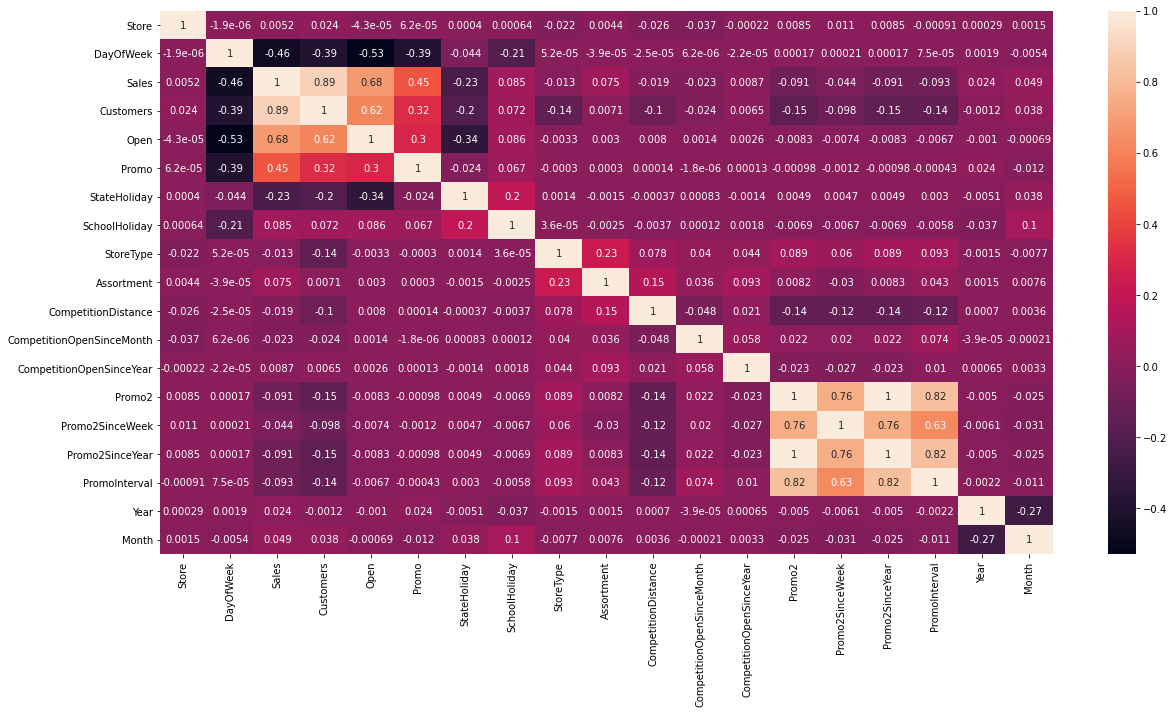

In [39]:
# calculating the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(combined_df.corr(),annot=True)

#### The correlation matrixs showed that:
- Sales was highly correlated to Open, Customers, and Promo
- Promo2 is highly correlated to PromoInterval and Promo2SinceWeek, and 
- Promo2SinceYear and PromoInterval are highly correlated 

Customers is a variables, which requires prediction by its own. Hence, it will be dropped subsequently. 

### Implementing Machine learning models

In [40]:
combined_df[combined_df['Open']==0]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
5,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
12,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
19,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
26,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
33,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017182,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017189,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017196,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017203,1115,7,0,0,0,0,0,1,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1


When the stores are closed (i.e. open == 0), the Sales are zero; hence, it doesn't make sense predicting zero Sales when the stores are closed. Hence, the Sales for open cases (i.e. open == 1) will be predicted by the model. At the stage of evaluation, the predictions for open and clsed cases will be combined. 

In [42]:
# using "Open" feature to divide the data into two classes
combined_df_subset = combined_df[combined_df['Open'] == 1]
combined_df_subset_closed = combined_df[combined_df['Open'] == 0]

X = combined_df_subset.drop(['Sales','Customers', 'Open'],axis=1)
Y = combined_df_subset['Sales']

X_train, X_test, y_train, y_test_open = train_test_split(X,Y,test_size=0.20)

In [43]:
X_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month'],
      dtype='object')

## Linear Regression

In [49]:
from sklearn import linear_model

LR_model = linear_model.LinearRegression() # making regression model
LR_model.fit(X_train, y_train) 

prediction_open = LR_model.predict(X_test)

prediction_closed = np.zeros(combined_df_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_df_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

r2_score:  0.7724588808226868
Mean absolute error: 1001.04
Root mean squared error:  1956.153456083559


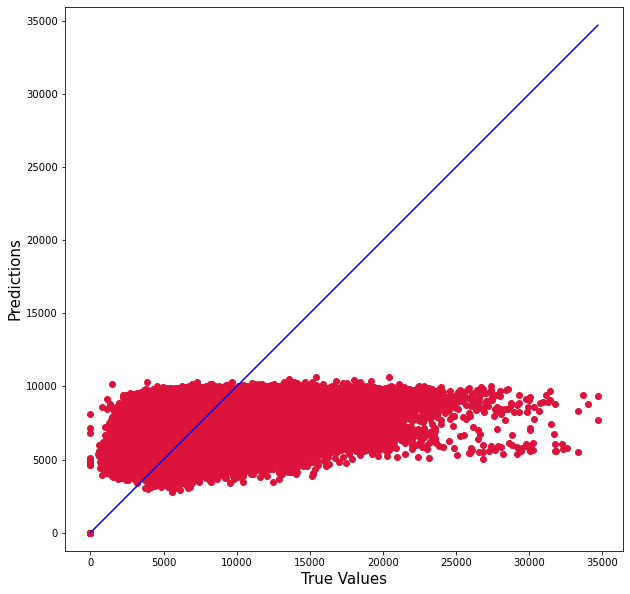

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Random Forest Regressor

r2_score:  0.9654785350398534
Mean absolute error: 356.29
Root mean squared error:  761.9344058068805


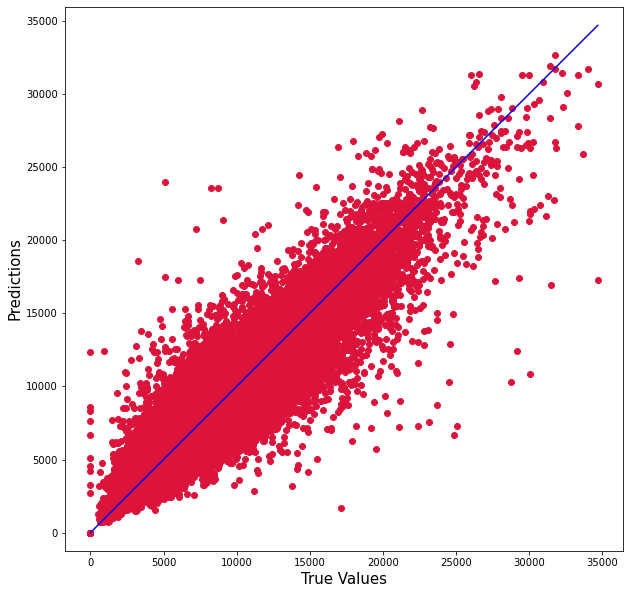

In [51]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor()
RF_model.fit(X_train,y_train)

prediction_open = RF_model.predict(X_test)
prediction_closed = np.zeros(combined_df_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_df_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Decision Tree Regressor

r2_score:  0.9520371649408217
Mean absolute error: 419.98
Root mean squared error:  898.1014537791935


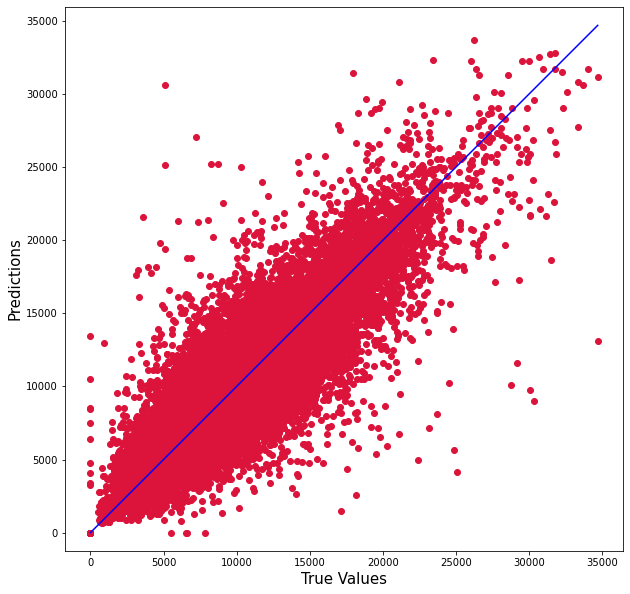

In [50]:
from sklearn.tree import DecisionTreeRegressor

DTR_model = DecisionTreeRegressor()
DTR_model.fit(X_train,y_train)

prediction_open = DTR_model.predict(X_test)
prediction_closed = np.zeros(combined_df_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_df_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Extreme Gredient Boosting Regressor

r2_score:  0.9566155995249787
Mean absolute error: 425.06
Root mean squared error:  854.1610754284984


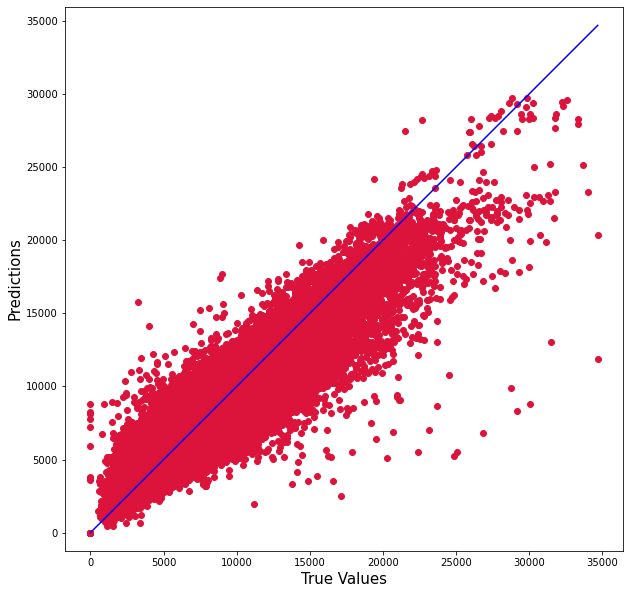

In [53]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor()
XGB_model.fit(X_train,y_train)

prediction_open = XGB_model.predict(X_test)
prediction_closed = np.zeros(combined_df_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_df_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Random Forest, Decision Tree, and XGBoost provided more or less similar Sales prediction; however, the Random Forest Regressor has a better edge with relatively higher r2 and smaller mean error. Hence, let's use the Random Forest Regressor model to identify the most important features.

## Understanding the important features


In [54]:
# getting weights of all the features used in the data
feature_importance = RF_model.feature_importances_
feature_importance

array([0.1757964 , 0.08260043, 0.13849005, 0.0014504 , 0.01264532,
       0.03627206, 0.03209785, 0.20568446, 0.06787844, 0.0808489 ,
       0.00294755, 0.03008734, 0.03290955, 0.01295966, 0.0239294 ,
       0.06340218])

In [55]:
# features used
feature_columns = list(X_train.columns)
feature_columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'Year',
 'Month']

In [56]:
feature_importance_value = []
for i in range(len(feature_importance)):
    feature_importance_value.append(round(feature_importance[i],5))
feature_importance_value

[0.1758,
 0.0826,
 0.13849,
 0.00145,
 0.01265,
 0.03627,
 0.0321,
 0.20568,
 0.06788,
 0.08085,
 0.00295,
 0.03009,
 0.03291,
 0.01296,
 0.02393,
 0.0634]

In [57]:
# making a dataframe
feature_importance_df = pd.DataFrame({"Features":feature_columns,
                                     "Values":feature_importance_value })
feature_importance_df

,Features,Values
0,Store,0.17580
1,DayOfWeek,0.08260
2,Promo,0.13849
3,StateHoliday,0.00145
4,SchoolHoliday,0.01265
5,StoreType,0.03627
6,Assortment,0.03210
7,CompetitionDistance,0.20568
8,CompetitionOpenSinceMonth,0.06788
9,CompetitionOpenSinceYear,0.08085


In [58]:
feature_importance_df.sort_values(by=["Values"], inplace=True, ascending=False)
feature_importance_df

,Features,Values
7,CompetitionDistance,0.20568
0,Store,0.17580
2,Promo,0.13849
1,DayOfWeek,0.08260
9,CompetitionOpenSinceYear,0.08085
8,CompetitionOpenSinceMonth,0.06788
15,Month,0.06340
5,StoreType,0.03627
12,Promo2SinceYear,0.03291
6,Assortment,0.03210


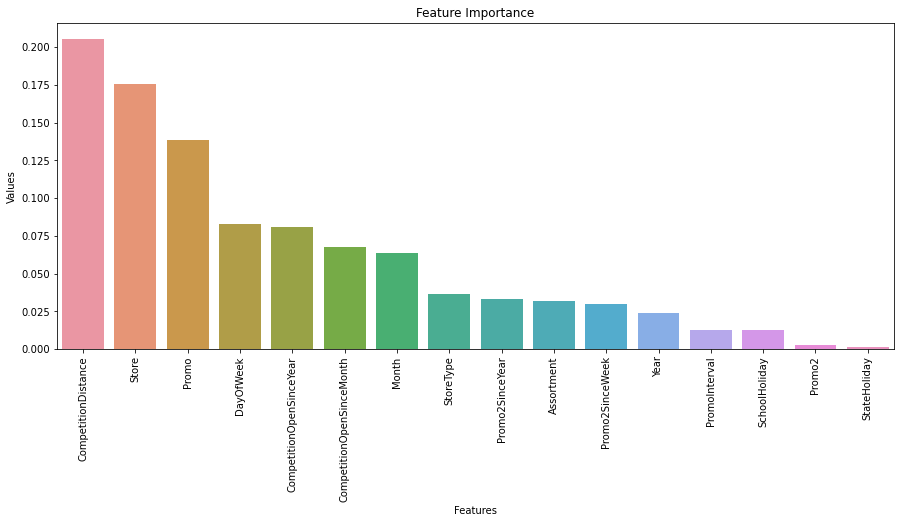

In [59]:
# Feature Importance
plt.figure(figsize=(15,6))

sns.barplot(x=feature_importance_df['Features'], y=feature_importance_df['Values'],
            data = feature_importance_df ).set(title='Feature Importance')

plt.xticks(rotation=90)
plt.show()

### Conclusion 
Compitition distance is the most important factor for sales. Likewise, Store unique id was a highly important factor. Promo feature, which indicates whether a store is running a promo on that day, has significant importance as well. PromoInterval, SchoolHoliday, Promo2 (i.e. Promo2 is a continuing and consecutive promotion for some stores), and StateHoliday have the least importance for the model prediction.  